<a href="https://colab.research.google.com/github/hungngo97/differential-neural-network/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1:  The Kuramoto-Sivashinsky (KS) equation.
In this KS system, we can think of it as time series data, where each row of pixels in the figure represent the system’s state and the data is moving across time-step row wise. In figure 4, the visualization has size 251 by 256so each state of the system has 256 variables and it moves across 251 timesteps. To examine the universal approximator of neural networks, we want to see if neural network can learn the mapping  to advance the solution from t to t + ∆t for the KS equation. To conduct this experiment, the paper constructs 10 different KS data with different initial parameters  that determine the number of complex pattern in the system as well as labels the data by assigning each state system with its corresponding next timestep future state. Next, we need to randomly split the dataset into train and test set with the ratio of 80/20 to illustrate the algorithm’s efficiency later. 

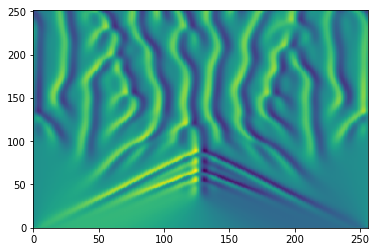

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Kuramoto-Sivashinsky equation (from Trefethen)
# u_t = -u*u_x - u_xx - u_xxxx,  periodic BCs 
def ks_equation(initial, modes):
  #Spatial grid and initial condition:
  N = modes;
  x = initial*np.pi*np.arange(1,N+1)/N;
  u = np.cos(x/16)*(1+np.sin(x/16)); 
  v = np.fft.fft(u);
  h = 0.025;
  k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])/16;
  L = k**2 - k**4;
  E = np.exp(h*L); E2 = np.exp(h*L/2);
  M = 16;
  r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
  LR = h*np.tile(L,(M,1)).T + np.tile(r,(N,1))
  Q = h*np.real(np.mean( (np.exp(LR/2)-1)/LR, axis=1)); 
  f1 = h*np.real(np.mean( (-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1)); 
  f2 = h*np.real(np.mean( (2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1));
  f3 = h*np.real(np.mean( (-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1));

  # Main time-stepping loop:
  uu = u; tt = 0;
  tmax = 100; nmax = round(tmax/h); nplt = np.floor((tmax/250)/h); g = -0.5j*k;
  for n in range(1,nmax+1):
      t = n*h;
      Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2);
      a = E2*v + Q*Nv;
      Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2);
      b = E2*v + Q*Na;
      Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2);
      c = E2*a + Q*(2*Nb-Nv);
      Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2);
      v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3; 
      if np.mod(n,nplt)==0:
          u = np.real(np.fft.ifft(v));
          uu = np.vstack([uu,u]); tt = np.append(tt,t);
  return (uu, tt)
uu , tt = ks_equation(32, 256)
uu2, tt2 = ks_equation(64, 256)
uu3, tt3 = ks_equation(128, 256)
uu4, tt4 = ks_equation(256, 256) 
uu5, tt5 = ks_equation(16, 256)
uu6, tt6 = ks_equation(100, 256)
uu7, tt7 = ks_equation(150, 256)
uu8, tt8 = ks_equation(25, 256)
uu9, tt9 = ks_equation(36, 256)
# Plot results:
plt.figure()
plt.pcolormesh(uu5)
plt.show()

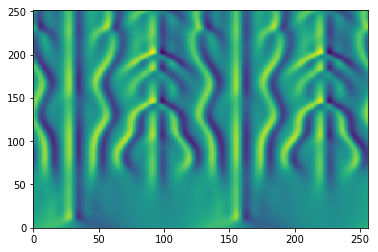

In [0]:
plt.figure()
plt.pcolormesh(uu2)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
x = uu[:-1, :]
y = uu[1:, :]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [0]:
for data in [uu2, uu3, uu4, uu5, uu6 , uu7, uu8, uu9]:
  x = data[:-1, :]
  y = data[1:, :]
  _X_train, _X_test, _y_train, _y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  X_train = np.vstack((X_train, _X_train))
  X_test = np.vstack((X_test, _X_test))
  y_train = np.vstack((y_train, _y_train))
  y_test = np.vstack((y_test, _y_test))

We use a fairly simple neural network with 2 hidden layers, each with 100 hidden units. To avoid overfitting, the neural network also contains regularizers such as dropout layer. The neural net use mean squared error as loss function because this loss is more suitable for a regression problems with no big difference between output values, which in section 3 we will examine other regression loss functions. We will train the neural net using stochastic gradient descent with learning rate  = 0.01. In summary, our time series regression neural network will receive input with 256 variables and through 2 hidden layers of 100 units and output a 256 variables state representing the next timestep. 

In [0]:
import torch
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.dropout = torch.nn.Dropout(p=0.4)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.dropout(h_relu)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, 256, 100, 256

# Create random Tensors to hold inputs and outputs
# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
# criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
trainLoss = []
for t in range(100):
#   Step through each time and the next timestep would be the desired output
#  for the current timestep
  for i in range(X_train.shape[0] - 1):
    x = torch.from_numpy(X_train[i,:]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.from_numpy(y_train[i,:]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    loss = criterion(y_pred, y)
    trainLoss.append(loss.item())
    if (t % 5 == 0 and i % 1000 == 0):
      trainLoss.append(loss.item())
#       print("[INFO] ", "Iteration: ", t, " Loss: ", loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Text(0, 0.5, 'Loss')

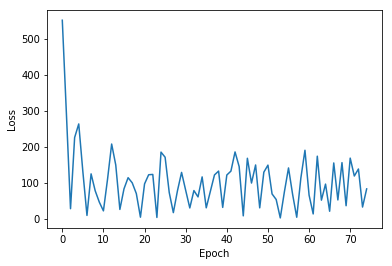

In [0]:
plt.plot(trainLoss[0:30000: 400])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
print("[INFO] Average Train Loss : " + str(sum(trainLoss) / len(trainLoss)))
print("[INFO] Min train Loss : " + str(min(trainLoss)))
print("[INFO] Last train loss: " + str(trainLoss[len(trainLoss) - 1]))

[INFO] Average Train Loss : 79.22676249168552
[INFO] Min train Loss : 1.6833652257919312
[INFO] Last train loss: 94.99842834472656


In [0]:
totalLoss = 0
testLoss = []
for i in range(X_test.shape[0] - 1):
    x = torch.from_numpy(X_test[i,:]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.from_numpy(y_test[i,:]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    criterion = torch.nn.MSELoss(reduction='sum')
    loss = criterion(y_pred, y)
#     print("[INFO] "," Loss: ", loss.item())
    totalLoss += loss.item()
    testLoss.append(loss.item())
    # Zero gradients, perform a backward pass, and update the weights.



avgLoss = totalLoss/X_test.shape[0] - 1
print("[INFO] Average test loss: " + str(avgLoss))
print("[INFO] Min train Loss : " + str(min(testLoss)))
print("[INFO] Last train loss: " + str(testLoss[len(testLoss) - 1]))

[INFO] Average test loss: 81.32807312516606
[INFO] Min train Loss : 3.0575780868530273
[INFO] Last train loss: 73.87110137939453


Text(0, 0.5, 'Loss')

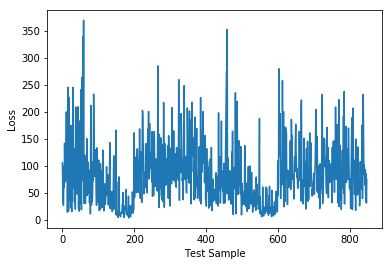

In [0]:
plt.plot(testLoss)
plt.xlabel('Test Sample')
plt.ylabel('Loss')

The train loss did receive a drop at around 10th epoch and seems to oscillate from there with the value of loss is approximately 100. Although we have not fully minimize the loss, which can be due to many reasons that we can improve by modifying our deep learning architectures to apply more hidden layers or more hidden units. Furthermore, we can greatly improve the learning process by creating more data since the data used in this paper is still relatively small which is only about 3400 samples for the training set. Let’s examine how this neural network perform on the test set. 

# Testing Dynamics
Now, let's try to compare evolution trajectories for NN approach against using the ODE time-stepper provided with different initial conditions to see if NN is able to learn the dynamics of the system

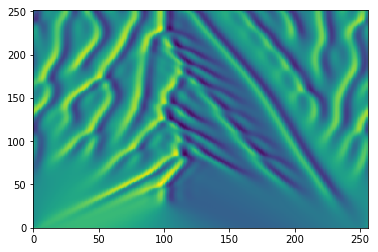

In [0]:
uu2, tt2 = ks_equation(20, 256)
plt.figure()
plt.pcolormesh(uu2)
plt.show()

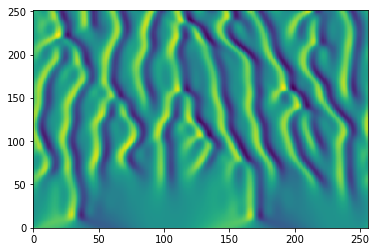

In [0]:
uu3, tt3 = ks_equation(60, 256)
plt.figure()
plt.pcolormesh(uu3)
plt.show()

In [0]:
def validate_individual_point(xtest):
  inp = xtest
  totalLoss = 0
  testLoss = []
  for i in range(inp.shape[0]):
      x = torch.from_numpy(inp[i - 1,:]).unsqueeze(0)
      x = x.float()
      # Forward pass: Compute predicted y by passing x to the model
      y_pred = model(x)
      y_pred = y_pred.float()
      y = torch.from_numpy(inp[i,:]).unsqueeze(0)
      y = y.float()
      # Compute and print loss
      criterion = torch.nn.MSELoss(reduction='sum')
      loss = criterion(y_pred, y)
#       print("[INFO] "," Loss: ", loss.item())
      totalLoss += loss.item()
      testLoss.append(loss.item())
  print("[INFO] Average Individual Loss " + str(totalLoss / len(testLoss)))
  return testLoss

def validate_trajectory(xtest,outputdim=0):
  inp = xtest
  totalLoss = 0
  testLoss = []
  current = torch.from_numpy(xtest[0,:]).unsqueeze(0)
  trajectory = [current]
  for i in range(inp.shape[0]):
#       x = torch.from_numpy(current).unsqueeze(0)
      x = current
      x = x.float()
      # Forward pass: Compute predicted y by passing x to the model
      y_pred = model(x)
      y_pred = y_pred.float()
      current = y_pred #Using current prediction to continue predict the entire path
      trajectory.append(y_pred)
      # Compute and print loss
      #Getting the true label
      y = torch.from_numpy(inp[i,:]).unsqueeze(0)
      y = y.float()
      criterion = torch.nn.MSELoss(reduction='sum')
      loss = criterion(y_pred, y)
#       print("[INFO] "," Loss: ", loss.item())
      totalLoss += loss.item()
      testLoss.append(loss.item())
  print("[INFO] Average Trajectory Loss " + str(totalLoss / len(testLoss)))
  
  #Convert trajectory into np array to visualize later
  res = np.zeros((len(trajectory), trajectory[0].shape[outputdim]))
  for i, val in enumerate(trajectory):
    val = val.detach().numpy()[0]
    for j in range(val.shape[0]):
      res[i][j] = val[j]
  return (testLoss, res)


[INFO] Average Individual Loss 186.98421993483586
[INFO] Average Trajectory Loss 358.20403323230516


Text(0, 0.5, 'Loss')

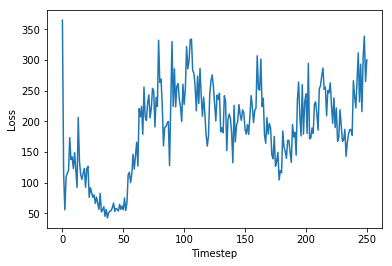

In [0]:
testLoss = validate_individual_point(uu3)
(testLossTrajectory, trajectory) = validate_trajectory(uu3, 1)
plt.plot(testLoss)
plt.xlabel('Timestep')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

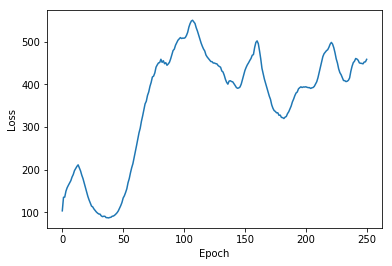

In [0]:
plt.plot(testLossTrajectory)
plt.xlabel('Epoch')
plt.ylabel('Loss')

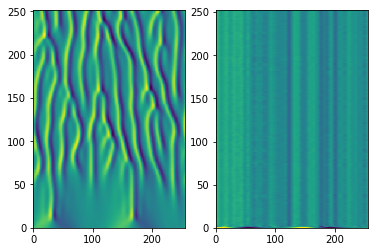

In [0]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.pcolormesh(uu3)

plt.subplot(1,2,2)
plt.pcolormesh(trajectory)
plt.show()

#Results
The neural network did not perform really well in this KS equation problem, although it can be vaguely see in the trajectory tests where although the neural network cannot predict the pattern of the whole time series (or the global “picture pixel pattern”), it still predict individual points quite well. For instance, at points where the original true labeled points is bright, the prediction seems to be bright and dark at other true dark points. In conclusion, it can be thought that the neural network can predict individual variable at next timestep pretty well given large enough dataset, but further improvement can be added in to extract the global features (the picture pattern) so it can learn its neighboring values. One proposal that we can think of is to predict the next time step value not just based on the current value, but we can as well include the values from previous few time steps, which will undoubtedly help the neural network to learn the whole time series pattern among variables. 

#  Reaction-diffusion system
 First project to a low-dimensional subspace via the SVD and see how
forecasting works in the low-rank variables

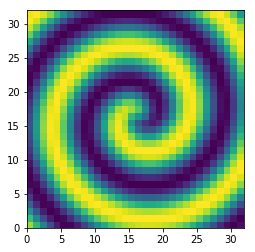

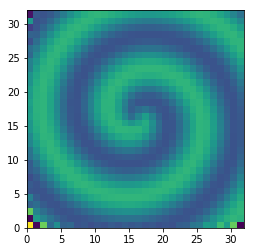

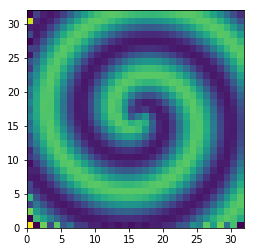

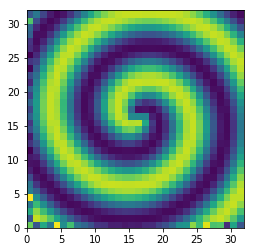

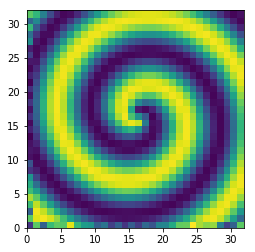

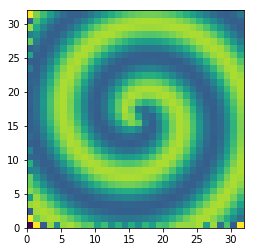

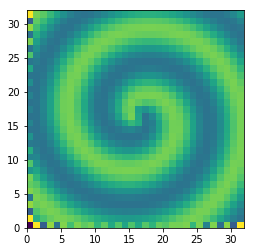

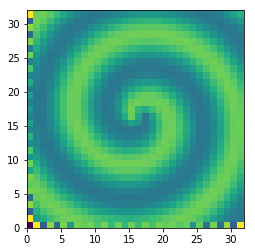

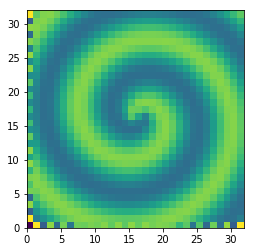

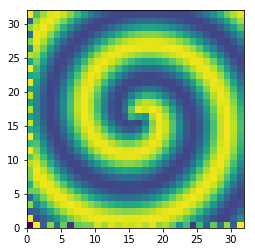

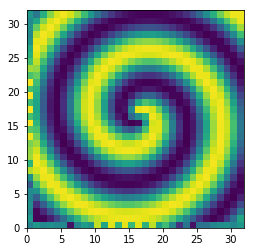

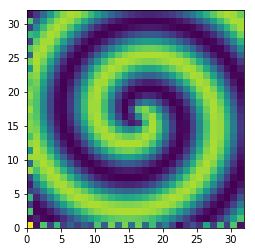

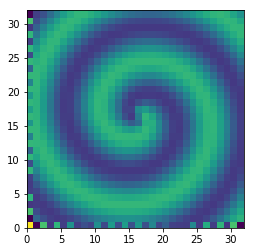

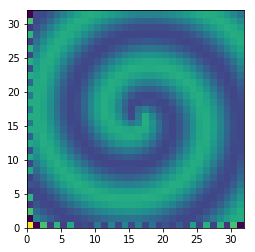

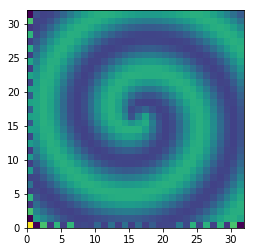

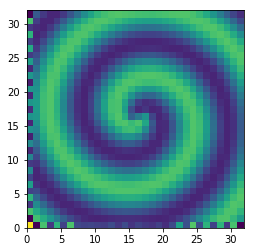

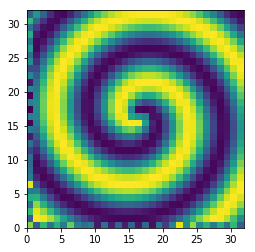

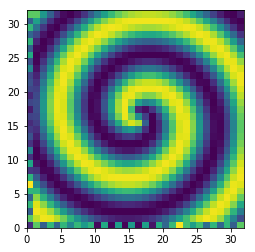

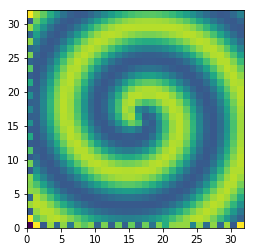

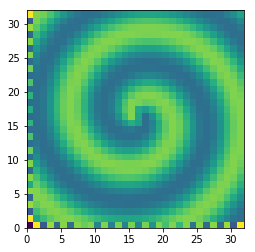

In [0]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def reaction_diffusion_rhs(t,uvt,K22,d1,d2,beta,n,N):
    # Calculate u and v terms
    ut=np.reshape(uvt[:N],(n,n));
    vt=np.reshape(uvt[N:],(n,n));
    u=np.real(np.fft.ifft2(ut)); v=np.real(np.fft.ifft2(vt));
    
    # Reaction Terms
    u3=u**3; v3=v**3; u2v=(u**2)*v; uv2=u*(v**2);
    utrhs=np.reshape(np.fft.fft2(u-u3-uv2+beta*u2v+beta*v3),(N,1));
    vtrhs=np.reshape(np.fft.fft2(v-u2v-v3-beta*u3-beta*uv2),(N,1));
    
    return np.concatenate([-d1*K22*uvt[:N]+utrhs, -d2*K22*uvt[N:]+vtrhs])[:,0]

# lambda-omega reaction-diffusion system
#  u_t = lam(A) u - ome(A) v + d1*(u_xx + u_yy) = 0
#  v_t = ome(A) u + lam(A) v + d2*(v_xx + v_yy) = 0
#
#  A^2 = u^2 + v^2 and
#  lam(A) = 1 - A^2
#  ome(A) = -beta*A^2

def reaction_diffusion(L, n):
  t=np.linspace(0,10,201);
  d1=0.1; d2=0.1; beta=1.0;
#   L=20; n=32; 
  N=n*n;
  x2=np.linspace(-L/2,L/2,n+1); x=x2[0:n]; y=x;
  kx=(2*np.pi/L)*np.concatenate([np.arange(0,n/2), np.arange(-n/2,0)]); ky=kx;

  # INITIAL CONDITIONS

  [X,Y]=np.meshgrid(x,y);
  [KX,KY]=np.meshgrid(kx,ky);
  K2=KX**2+KY**2; K22=np.reshape(K2,(N,1));

  m=1; # number of spirals

  u = np.zeros((len(x),len(y),len(t)));
  v = np.zeros((len(x),len(y),len(t)));

  u[:,:,0]=np.tanh(np.sqrt(X**2+Y**2))*np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));
  v[:,:,0]=np.tanh(np.sqrt(X**2+Y**2))*np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));

  # REACTION-DIFFUSION
  uvt=np.concatenate([np.reshape(np.fft.fft2(u[:,:,0]).T,(N,1)), np.reshape(np.fft.fft2(v[:,:,0]).T,(N,1))]);
  #uvsol=integrate.complex_ode(reaction_diffusion_rhs,uvt[:,0],t,args=(K22,d1,d2,beta,n,N));
  sol=integrate.solve_ivp(lambda t,u: reaction_diffusion_rhs(t,u,K22,d1,d2,beta,n,N),[0,10],uvt[:,0],t_eval=t,method='RK45');
  uvsol = sol.y

  #%%
  for j in range(len(t)-1):
      ut=np.reshape(uvsol[:N,j+1],(n,n));
      vt=np.reshape(uvsol[N:,j+1],(n,n));
      u[:,:,j+1]=np.real(np.fft.ifft2(ut));
      v[:,:,j+1]=np.real(np.fft.ifft2(vt));
  return v
  # np.savez('reaction_diffusion_big.npz',t=t,x=x,y=y,u=u,v=v)
  
  
v = reaction_diffusion(20, 32)
v1 = reaction_diffusion(40, 32)
v2 = reaction_diffusion(10, 32)
v3 = reaction_diffusion(50, 32)
for j in np.arange(0,200,10):
    plt.figure()
    plt.pcolormesh(v[:,:,j])
    plt.axis('image')

The reaction diffusion data can be thought of as a time series of spiral frames (32 by 32 pixel) where the pixel intensity variates among timesteps. So, similar to the previous section, we consider one frame as the state of our system and use that state as an input to our neural network to predict the next state, or in our case, the next spiral pixel frame. First, we can start building the dataset by performing some image processing techniques such as concatenate each row of pixels into one large vector of values, which give us a vector of shape (1024 by 1). Afterwards, we can continue to horizontal stack each vector timestep to build a large time series matrix X where each column represent a system state (1024 by 201 timesteps) Although we can directly input that state into our neural network, but it would be computationally expensive to propagate the neural network with 1024 input units and 1024 output units, not including the hidden units from the hidden layers. Therefore, one new approach can be proposed to perform dimensionality reduction on the input data by performing singular value decomposition on the input data and then project the high dimensional input data to a lower dimension and use that compressed  data as input to our neural network. 
X = U S V
After performing SVD on the matrix X, we can examine its singular values to determine the rank truncation:


In [0]:
def reshape_image_state(v):
  rows, cols, steps = v.shape
  x = None
  for t in range(steps):
    #State of the system in the current t
    current = None
    for row in range(rows):
      if current is None:
        current = np.reshape(v[row, :, t], (-1, 1))
      else:
        current = np.vstack((current, np.reshape(v[row, :, t], (-1, 1))))
    if x is None:
      #First timestep
      x = current
    else:
      #Append the next state of the system
      x = np.hstack((x, current))
  return x
#x = (1024, 201) with state of system = 1024 and 201 timesteps

In [0]:
x = reshape_image_state(v)
U, S, V = np.linalg.svd(x, full_matrices=True)
U.shape, S.shape, V.shape

((1024, 1024), (201,), (201, 201))

[INFO] Rank 0 : 44.00173315453072%
[INFO] Rank 1 : 39.64667093447748%
[INFO] Rank 2 : 4.336391447310728%
[INFO] Rank 3 : 4.113954520947203%
[INFO] Rank 4 : 2.4841604012512573%
[INFO] Rank 5 : 1.8479546795495805%
[INFO] Rank 6 : 1.0634797624335088%
[INFO] Rank 7 : 0.8892298383315961%
[INFO] Rank 8 : 0.6029007345511053%
[INFO] Rank 9 : 0.37104361782700934%


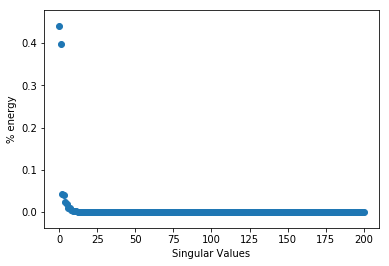

In [0]:
plt.scatter(range(S.shape[0]), S / sum(S))
plt.xlabel('Singular Values')
plt.ylabel('% energy')
for i in range(10):
  print("[INFO] Rank " + str(i) + " : " + str(S[i] / sum(S) * 100) + "%")

In [0]:
# S * V = (6 x 6) * (6 x 201) = (6, 201)
# U * X = (6, 1024) * (1024 * 201) = (6, 201)
# Projection:   (6,1024)      * (1024 * 1) = U * new_x = (6, 1) 
smat = np.zeros((6, 6), dtype=complex)
smat[:6, :6] = np.diag(S[:6])
x_r = np.dot(smat,V[:6, :])

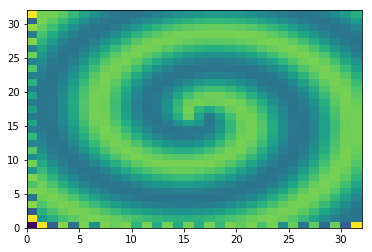

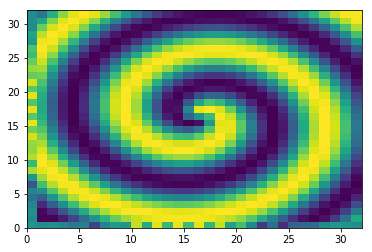

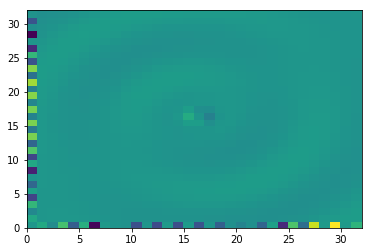

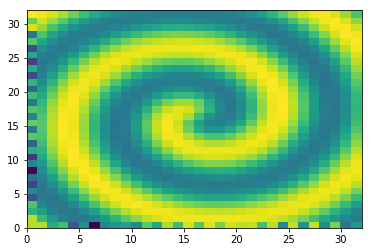

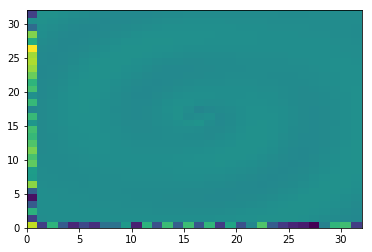

In [0]:
for i in range(5):
  plt.figure()
  a = np.reshape(U[:, i], (32, 32))
  plt.pcolormesh(a)

In [0]:
# Build train and test data
X_train = None
X_test = None
y_train = None
y_test = None
for data in [v, v1, v2, v3]:
  x = reshape_image_state(data)
  U, S, V = np.linalg.svd(x, full_matrices=True)
  smat = np.zeros((6, 6), dtype=complex)
  smat[:6, :6] = np.diag(S[:6])
  x_r = np.transpose(np.dot(smat,V[:6, :]))
  print(x_r.shape)
  x = x_r[:-1, :]
  y = x_r[1:, :]
  _X_train, _X_test, _y_train, _y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  X_train = _X_train if X_train is None else np.vstack((X_train, _X_train))
  X_test = _X_test if X_test is None else np.vstack((X_test, _X_test))
  y_train = _y_train if y_train is None else np.vstack((y_train, _y_train))
  y_test = _y_test if y_test is None else np.vstack((y_test, _y_test))
  
X_train = np.transpose(X_train.real)
X_test = np.transpose(X_test.real)
y_train = np.transpose(y_train.real)
y_test = np.transpose(y_test.real)

(201, 6)
(201, 6)
(201, 6)
(201, 6)


In [0]:
import torch
class ReactionDiffusionNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ReactionDiffusionNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, 6, 15, 6

# Create random Tensors to hold inputs and outputs

# x = torch.randn(N, D_in)
# y = torch.randn(N, D_out)


# Construct our model by instantiating the class defined above
model = ReactionDiffusionNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
trainLoss = []
for t in range(100):
#   Step through each time and the next timestep would be the desired output
#  for the current timestep
  for i in range(X_train.shape[0] - 1):
    x = torch.from_numpy(X_train[:, i]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.from_numpy(y_train[:, i]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    loss = criterion(y_pred, y)
    trainLoss.append(loss.item())
    if (t % 20 == 0):
      print("[INFO] ", "Iteration: ", t, " Loss: ", loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[INFO]  Iteration:  0  Loss:  549.1506958007812
[INFO]  Iteration:  0  Loss:  513.560546875
[INFO]  Iteration:  0  Loss:  504.5073547363281
[INFO]  Iteration:  0  Loss:  437.8487854003906
[INFO]  Iteration:  0  Loss:  548.43896484375
[INFO]  Iteration:  20  Loss:  14.449644088745117
[INFO]  Iteration:  20  Loss:  15.279552459716797
[INFO]  Iteration:  20  Loss:  18.672746658325195
[INFO]  Iteration:  20  Loss:  6.774633407592773
[INFO]  Iteration:  20  Loss:  0.5498457551002502
[INFO]  Iteration:  40  Loss:  11.285072326660156
[INFO]  Iteration:  40  Loss:  12.019814491271973
[INFO]  Iteration:  40  Loss:  5.323594093322754
[INFO]  Iteration:  40  Loss:  3.5201501846313477
[INFO]  Iteration:  40  Loss:  0.7213632464408875
[INFO]  Iteration:  60  Loss:  8.718339920043945
[INFO]  Iteration:  60  Loss:  9.130439758300781
[INFO]  Iteration:  60  Loss:  2.1609344482421875
[INFO]  Iteration:  60  Loss:  1.7682034969329834
[INFO]  Iteration:  60  Loss:  0.47350725531578064
[INFO]  Iteration: 

Text(0.5, 1.0, 'Training Loss')

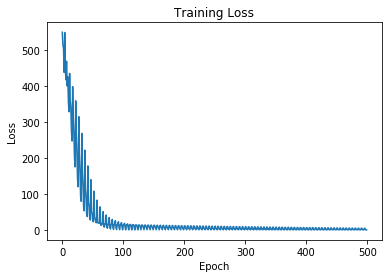

In [0]:
plt.plot(trainLoss)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Training Loss")

[INFO] Average Train Loss : 30.500666671097278
[INFO] Min train Loss : 0.28637588024139404
[INFO] Last train loss: 0.28637588024139404
[INFO] Average test loss: 16.504117044309776


Text(0.5, 1.0, 'Testing Loss')

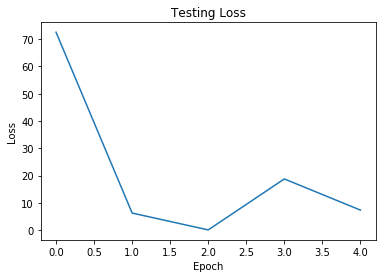

In [0]:
print("[INFO] Average Train Loss : " + str(sum(trainLoss) / len(trainLoss)))
print("[INFO] Min train Loss : " + str(min(trainLoss)))
print("[INFO] Last train loss: " + str(trainLoss[len(trainLoss) - 1]))
totalLoss = 0
testLoss = []
for i in range(X_test.shape[0] - 1):
    x = torch.from_numpy(X_test[:,i]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.from_numpy(y_test[:,i]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    criterion = torch.nn.MSELoss(reduction='sum')
    loss = criterion(y_pred, y)
#     print("[INFO] "," Loss: ", loss.item())
    totalLoss += loss.item()
    testLoss.append(loss.item())
    # Zero gradients, perform a backward pass, and update the weights.



avgLoss = totalLoss/X_test.shape[0] - 1
print("[INFO] Average test loss: " + str(avgLoss))
plt.plot(testLoss)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Testing Loss")

[INFO] Average Trajectory Loss 586.6322522878647
[INFO] Average Individual Loss 706.4190824836493


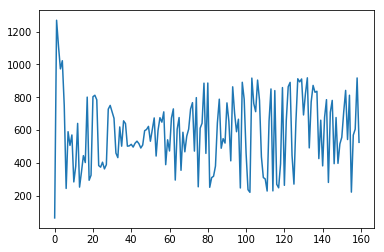

In [0]:
testLoss, trajectory = validate_trajectory(np.transpose(X_test), 1)
individualLoss = validate_individual_point(np.transpose(X_test))
plt.plot(testLoss)

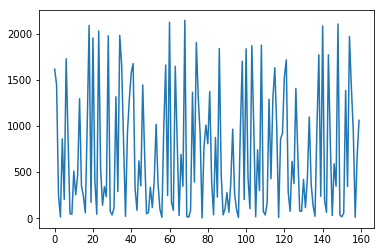

In [0]:
plt.plot(individualLoss)

# Lorenz Integration


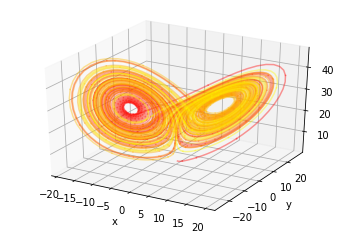

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Lorenz paramters and initial conditions
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 0, 1, 1.05

# Maximum time point and total number of time points
tmax, n = 100, 10000

def lorenz(X, t, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

# Integrate the Lorenz equations on the time grid t
t = np.linspace(0, tmax, n)
f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, rho))
x, y, z = f.T

# Plot the Lorenz attractor using a Matplotlib 3D projection
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
c = np.linspace(0,1,n)
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=(1,c[i],0), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [0]:
# Build train and test data
X_train = None
X_test = None
y_train = None
y_test = None
for r in [10, 28, 40]:
  t = np.linspace(0, tmax, n)
  f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, r))
  x, y, z = f.T
  data = np.array([list(a + (r, )) for a in zip(x, y, z)])
  print(data.shape)
  x = data[:-1, :]
  y = data[1:, :]
  _X_train, _X_test, _y_train, _y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  X_train = _X_train if X_train is None else np.vstack((X_train, _X_train))
  X_test = _X_test if X_test is None else np.vstack((X_test, _X_test))
  y_train = _y_train if y_train is None else np.vstack((y_train, _y_train))
  y_test = _y_test if y_test is None else np.vstack((y_test, _y_test))
X_train = np.transpose(X_train.real)
X_test = np.transpose(X_test.real)
y_train = np.transpose(y_train.real)
y_test = np.transpose(y_test.real)

(10000, 4)
(10000, 4)
(10000, 4)


[INFO]  Iteration:  0  Loss:  235.68984985351562
[INFO]  Iteration:  0  Loss:  227.06512451171875
[INFO]  Iteration:  0  Loss:  218.8767547607422
[INFO]  Iteration:  20  Loss:  0.8019720315933228
[INFO]  Iteration:  20  Loss:  0.7077898979187012
[INFO]  Iteration:  20  Loss:  0.6242353916168213
[INFO]  Iteration:  40  Loss:  0.001270467066206038
[INFO]  Iteration:  40  Loss:  0.001181608997285366
[INFO]  Iteration:  40  Loss:  0.0010538160568103194
[INFO]  Iteration:  60  Loss:  2.357006451347843e-06
[INFO]  Iteration:  60  Loss:  3.7158965824346524e-06
[INFO]  Iteration:  60  Loss:  2.5791534881136613e-06
[INFO]  Iteration:  80  Loss:  9.077939466806129e-08
[INFO]  Iteration:  80  Loss:  2.0724587557197083e-07
[INFO]  Iteration:  80  Loss:  2.814545041474048e-08


Text(0.5, 1.0, 'Training loss')

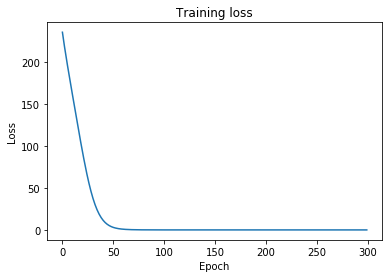

In [0]:
import torch
class LorenzNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LorenzNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, 4, 15, 4

# Construct our model by instantiating the class defined above
model = LorenzNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
trainLoss = []
for t in range(100):
#   Step through each time and the next timestep would be the desired output
#  for the current timestep
  for i in range(X_train.shape[0] - 1):
    x = torch.from_numpy(X_train[:, i]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.from_numpy(y_train[:, i]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    loss = criterion(y_pred, y)
    trainLoss.append(loss.item())
    if (t % 20 == 0):
      print("[INFO] ", "Iteration: ", t, " Loss: ", loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(trainLoss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training loss")

[INFO] Average Train Loss : 14.239801877626839
[INFO] Min train Loss : 1.9839717424474657e-08
[INFO] Last train loss: 1.9839717424474657e-08
[INFO] Average test loss: 909774.664841739


Text(0.5, 1.0, 'Test Loss')

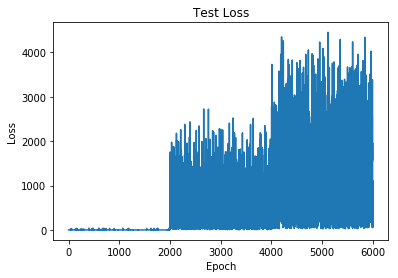

In [0]:
print("[INFO] Average Train Loss : " + str(sum(trainLoss) / len(trainLoss)))
print("[INFO] Min train Loss : " + str(min(trainLoss)))
print("[INFO] Last train loss: " + str(trainLoss[len(trainLoss) - 1]))
totalLoss = 0
testLoss = []
for i in range(X_test.shape[1]):
#     print(i)
    x = torch.from_numpy(X_test[:,i]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.from_numpy(y_test[:,i]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    criterion = torch.nn.MSELoss(reduction='sum')
    loss = criterion(y_pred, y)
#     print("[INFO] "," Loss: ", loss.item())
    totalLoss += loss.item()
    testLoss.append(loss.item())
    # Zero gradients, perform a backward pass, and update the weights.



avgLoss = totalLoss/X_test.shape[0] - 1
print("[INFO] Average test loss: " + str(avgLoss))
plt.plot(testLoss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')


# Test with new unseen Lorenz path

In [0]:
t = np.linspace(0, tmax, n)
rho = 35
f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, rho))
x, y, z = f.T
data = np.array([list(a + (rho, )) for a in zip(x, y, z)])



[INFO] Average Trajectory Loss nan
[INFO] Average Individual Loss 886.6041755256653


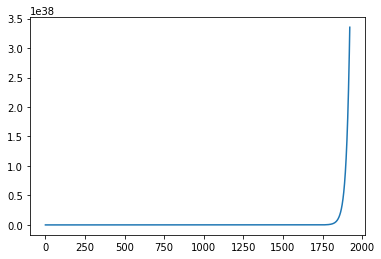

In [0]:
testLoss, trajectory = validate_trajectory(data, 1)
individualLoss = validate_individual_point(data)
plt.plot(testLoss)

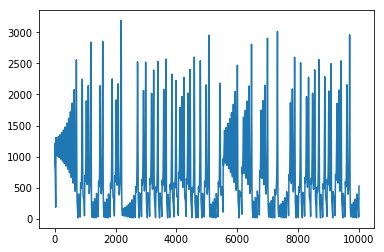

In [0]:
plt.plot(individualLoss)

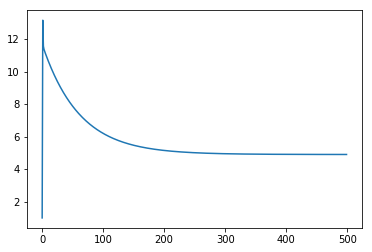

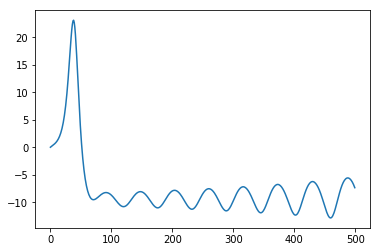

In [0]:
# Plot the Lorenz attractor using a Matplotlib 3D projection
fig = plt.figure()
plt.plot(trajectory[:500, 1])

fig2 = plt.figure()
plt.plot(x[:500])

#  Training a neural net (for ρ = 28) when a transition from one lobe to another is imminent
In this section, we will explore the accuracy of neural network on a classic differential dataset, which is the Lorenz system and we wanted to train the neural network with similar behaviours from the two previous sections by predicting the value of the next time step based on the current timestep. In the Lorenz system state, we have 3 variables x, y, z which describes the spatial location on the 3D coordinate system and it describes the trajectory of an object following a “butterfly” shape across spatial domain. In this problem , we will modify the initial condition ρ of the Lorenz system and try to see if the neural network can learn different patterns of the Lorenz system with different ρ value. Our neural net architecture is still similar with the two previous sections , with a change in the input size as 4 variables and the hidden layer now have 10 variables. 
Another interesting application that this paper explores with the Lorenz system is to train a neural network to identify (for ρ = 28) when a transition from one lobe to another is imminent. In our case, we will want to predict how many timesteps in the future that the point is about to swap between the two lobes of the Lorenz system. To label lobe transitions, we pick a plane separating the two lobes at x = 0 and count the how many timestep to the future that the current timestep  crosses the plane.
However, the neural network perform really bad on the test set by always output same similar value, approximately 150 timesteps. One reason to explain for this behaviour of the neural network is that our data is extremely unbalanced regarding the 100-300 timesteps label range ( around 9000 labels) compared to that of the lower timesteps ( which on average is around 3000 labels) , so that the neural network cannot learn well the timesteps at other range, as a result, it decides to always output values regarding the popular range in the training dataset will always guarantee it a better train loss. One improvement we can work on this is to balance the dataset by either increasing the amount of labels to improve the learning. 

(10000, 3)


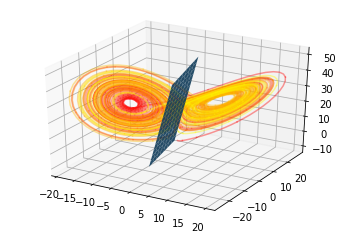

In [0]:
t = np.linspace(0, tmax, n)
f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, 28))
x, y, z = f.T
data = np.array([list(a) for a in zip(x, y, z)])
print(data.shape)



# VISUALIZING PLOT
# Plot the Lorenz attractor using a Matplotlib 3D projection
fig = plt.figure()
ax = fig.gca(projection='3d')

s = 10
c = np.linspace(0,1,n)
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=(1,c[i],0), alpha=0.4)
# Remove all the axis clutter, leaving just the curve.
# create x,y
xx, yy = np.meshgrid(range(-4,4), range(-8,8))
point  = np.array([1, 2, 3])
normal = np.array([1, 1, 2])
# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# calculate corresponding z

# z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
z = -6 *(-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2] + 50
ax.plot_surface(xx, yy, z, alpha=0.9)


In [0]:
labels = []
forward = 30000
for i in range(data.shape[0]):
  t = -1 #originally we don't know when the next sign change would be
#   Check if the next 10 points has opposite sign, if it is, the next axis change
#   will be the point that has opposite sign of x value with current point
  for step in range(data.shape[0]):
    if (i + step) >= data.shape[0] or i >= forward: 
      break
    if data[i][0] * data[i + step][0] < 0:
      t = step
      labels.append((i, t))
      break

In [0]:
start = 4000 #Because there seems to be noise in the front which did not capture
# the dynamics of the whole pattern
x = data[start:len(labels), :]
y = np.array(labels)[start:, 1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [0]:
a, b = np.histogram(labels, bins=np.arange(100, 1500, 200))
print(a)
print(b)



[3684 1413  773  443  400  402]
[ 100  300  500  700  900 1100 1300]


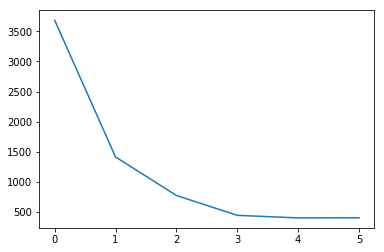

In [0]:
plt.plot(a)

Text(0, 0.5, 'Label')

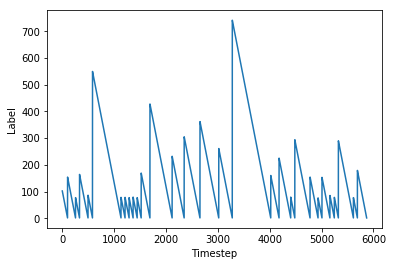

In [0]:
plt.plot(y)
plt.xlabel('Timestep')
plt.ylabel('Label')

In [0]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, 3, 10, 1

# Create random Tensors to hold inputs and outputs
# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
trainLoss = []
for t in range(10):
#   Step through each time and the next timestep would be the desired output
#  for the current timestep
  for i in range(X_train.shape[0] - 1):
    x = torch.from_numpy(X_train[i,:]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
#     y = torch.from_numpy(y_train[i]).unsqueeze(0)
    y = torch.tensor([[y_train[i]]])
    y = y.float()
    # Compute and print loss
    loss = criterion(y_pred, y)
    trainLoss.append(loss.item())
    if (t % 5 == 0 and i % 200 == 0):
      print("[INFO] Prediction: ", y_pred, "Actual: ", y)
      print("[INFO] ", "Time : ", t, "Iteration: ", i, " Loss: ", loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[INFO] Prediction:  tensor([[-1.2377]], grad_fn=<AddmmBackward>) Actual:  tensor([[90.]])
[INFO]  Time :  0 Iteration:  0  Loss:  91.23765563964844
[INFO] Prediction:  tensor([[8.7267]], grad_fn=<AddmmBackward>) Actual:  tensor([[12.]])
[INFO]  Time :  0 Iteration:  200  Loss:  3.273310661315918
[INFO] Prediction:  tensor([[17.2267]], grad_fn=<AddmmBackward>) Actual:  tensor([[35.]])
[INFO]  Time :  0 Iteration:  400  Loss:  17.77330207824707
[INFO] Prediction:  tensor([[25.5266]], grad_fn=<AddmmBackward>) Actual:  tensor([[123.]])
[INFO]  Time :  0 Iteration:  600  Loss:  97.47342681884766
[INFO] Prediction:  tensor([[32.8265]], grad_fn=<AddmmBackward>) Actual:  tensor([[72.]])
[INFO]  Time :  0 Iteration:  800  Loss:  39.17353820800781
[INFO] Prediction:  tensor([[39.1264]], grad_fn=<AddmmBackward>) Actual:  tensor([[215.]])
[INFO]  Time :  0 Iteration:  1000  Loss:  175.87362670898438
[INFO] Prediction:  tensor([[44.5263]], grad_fn=<AddmmBackward>) Actual:  tensor([[89.]])
[INFO]  T

[INFO] Average Train Loss : 110.46035669496392
[INFO] Min train Loss : 0.021026611328125
[INFO] Last train loss: 111.22097778320312


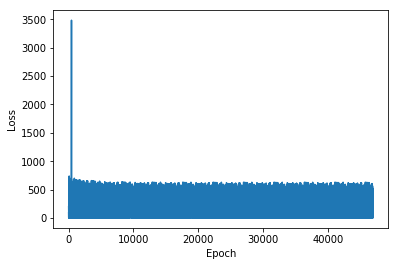

In [0]:
plt.plot(trainLoss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
print("[INFO] Average Train Loss : " + str(sum(trainLoss) / len(trainLoss)))
print("[INFO] Min train Loss : " + str(min(trainLoss)))
print("[INFO] Last train loss: " + str(trainLoss[len(trainLoss) - 1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:804: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[303.]]])
[INFO]  Iteration:  0  Loss:  188.6709747314453
[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[82.]]])
[INFO]  Iteration:  20  Loss:  31.329025268554688
[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[28.]]])
[INFO]  Iteration:  40  Loss:  85.32902526855469
[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[35.]]])
[INFO]  Iteration:  60  Loss:  78.32902526855469
[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[254.]]])
[INFO]  Iteration:  80  Loss:  139.6709747314453
[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[39.]]])
[INFO]  Iteration:  100  Loss:  74.32902526855469
[INFO] Prediction:  tensor([[113.8290]], grad_fn=<AddmmBackward>) Actual:  tensor([[[85.]]])
[INFO]  Iteration:  120  Loss:  28.329025268554688
[

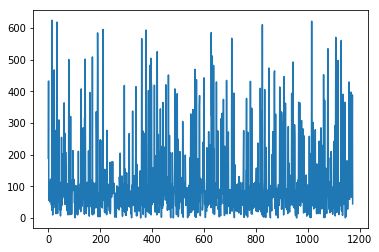

In [0]:
totalLoss = 0
testLoss = []
for i in range(X_test.shape[0] - 1):
    x = torch.from_numpy(X_test[i,:]).unsqueeze(0)
    x = x.float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    y_pred = y_pred.float()
    y = torch.tensor([[y_test[i]]]).unsqueeze(0)
    y = y.float()
    # Compute and print loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(y_pred, y)
    if (i % 20 == 0):
      print("[INFO] Prediction: ", y_pred, "Actual: ", y)
      print("[INFO] ", "Iteration: ", i, " Loss: ", loss.item())
#     print("[INFO] "," Loss: ", loss.item())
    totalLoss += loss.item()
    testLoss.append(loss.item())
    # Zero gradients, perform a backward pass, and update the weights.



avgLoss = totalLoss/X_test.shape[0] - 1
print("[INFO] Average test loss: " + str(avgLoss))
plt.plot(testLoss)

In [0]:
model(torch.from_numpy(X_train[1000,:]).unsqueeze(0).float())

tensor([[121.3392]], grad_fn=<AddmmBackward>)